# 5 Structured Prediction 


NOTE: This notebook follows from the notebook on Text classification.
This notebook contains all of the structured prediction procedures we ran to try and respond to research question three as outlined in the notebook on cleaning annd exploratory analysis. The research question of note here is: 

Can we build an effective POS tagger that is specialised on italian political language ?

# 5.1 Structured Perceptron 

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv("cleaned_nonans.csv")
data = data[['words','pos_tags']]

In [ ]:
words = []
for row in range(data.shape[0]):
    trans = data.words[row].split()
    sentence = []
    for word in trans:
        sentence.append(word)
    words.append(sentence)

In [ ]:
pos_tags = []
for row in range(data.shape[0]):
    trans = data.pos_tags[row].split()
    sentence = []
    for tag in trans:
        sentence.append(tag)
    pos_tags.append(sentence)

In [ ]:
clean_words = []
clean_tags = []

for i in range(len(words)):
    sentence_w = []
    sentence_t = []
    for j in range(len(words[i])):
        if pos_tags[i][j] != "_":
            sentence_w.append(words[i][j])
            sentence_t.append(pos_tags[i][j])
    clean_words.append(sentence_w)
    clean_tags.append(sentence_t)
    
    

In [ ]:
len(clean_words)==len(clean_tags), len(clean_words)

(True, 13170)

In [ ]:
np.random.seed(2)
a = np.arange(len(clean_words))
np.random.shuffle(a)
train_index = a[:len(clean_words)*3//5]
dev_index = a[len(clean_words)*3//5:len(clean_words)*4//5]
test_index = a[len(clean_words)*4//5:]


In [ ]:
train_words = []
train_tags = []
for i in train_index:
    train_words.append(clean_words[i])
    train_tags.append(clean_tags[i])
dev_words = []
dev_tags = []
for i in dev_index:
    dev_words.append(clean_words[i])
    dev_tags.append(clean_tags[i])
test_words = []
test_tags = []
for i in test_index:
    test_words.append(clean_words[i])
    test_tags.append(clean_tags[i])

In [ ]:
train_file = pd.DataFrame({'words':train_words,'tags':train_tags})
dev_file = pd.DataFrame({'words':dev_words,'tags':dev_tags})
test_file = pd.DataFrame({'words':test_words,'tags':test_tags})

In [42]:
from collections import defaultdict, Counter
import json
import re
import numpy as np
import sys
import pickle
import random

np.set_printoptions(precision=2)

users = re.compile('@[^ ]+')
numbers = re.compile('[0-9]')
urls = re.compile("(https?:\/\/)?(?:www\.|(?!www))?[^\s\.]+\.[^\s]{2,}|(www)?\.[^\s]+\.[^\s]{2,}")

We have modified the Structured Perceptron so that it was able to train directly on DataFrames.
The major modifications have been done on the features that the algorithm stores for the corpus, in fact, as our dataset is composed of italian sentences, we wanted to account for some of the variables that may have a huge impact in the italian linguistic structure. We, indeed accounted for the adverbs suffixes (the last five words in the word), which are constant in italian and corresponds to -MENTE. We accounted also for those for the previous and the next word, as the easier the model gets the adverb the easier is able to understand its surrounding. Moreover, we considered the last letter of the single word, as in Italian language the last word may present the accent, giving to the word a complete different meaning (pero != però). The remaining features were left similar to english,as italian, even if with some differencies (adjective after the name) tend to keep the same ordinal structure present in the english language (name + verb + object). Indeed, we had previously began by running a structured perceptron without these features and after adding them we did not see significant performance. However, we decided to keep this version with the new features as, consistent with the aim of our project, they could be of help and provide significant improvements to other researchers working with italian data.

In [35]:
class StructuredPerceptron(object):

    def __init__(self):
        self.tags = set()
        self.feature_weights = defaultdict(lambda: defaultdict(float)) 
        self.weight_totals = defaultdict(lambda: defaultdict(float)) 
        self.timestamps = defaultdict(lambda: defaultdict(float)) 

        self.tag_dict = defaultdict(set) 
        self.train_accuracy = []
        self.dev_accuracy = []

        self.START = "__START__"
        self.END = "__END__"
        
        
    def normalize(self, word):
        return re.sub(urls, 'URL', re.sub(users, '@USER', re.sub(numbers, '0', word.strip().lower())))

    
    def evaluate(self, data_instances, method='greedy'):
        correct = 0
        total = 0
        for (words, tags) in data_instances:
            preds = self.predict(words, method=method)
            matches = sum(map(lambda x: int(x[0]==x[1]), zip(preds, tags)))
            correct += matches
            total += len(tags)
        
        return correct/total
        
    
    def fit(self,train_file, 
            dev_file=None, 
            iterations=10, 
            learning_rate=0.25, 
            inference='greedy', 
            verbose=False):
        
        instances = [(words, tags) for (words, tags) in zip(train_file.words,train_file.tags)]
        for (words, tags) in instances:
            self.tags.update(set(tags))

            for word, tag in zip(words, tags):
                self.tag_dict[self.normalize(word)].add(tag)
        
        if dev_file is not None:
            dev_instances = [(words, tags) for (words, tags) in zip(dev_file.words,dev_file.tags)]
            
        for iteration in range(1, iterations+1):
            correct = 0
            total = 0
            if verbose:
                print('Iteration {}'.format(iteration+1), file=sys.stderr, flush=True)
                print("*" * 15, file=sys.stderr, flush=True)

            random.shuffle(instances) 
            for i, (words, tags) in enumerate(instances):
                if i > 0:
                    if i%1000==0:
                        print('%s'%i, file=sys.stderr, flush=True)
                    elif i%20==0:
                        print('.', file=sys.stderr, flush=True, end='')

                prediction = self.predict(words, method=inference) #list of words

                global_gold_features, global_prediction_features = self.get_global_features(words, prediction, tags)
                                    
                
                for tag, fids in global_gold_features.items():
                    for fid, count in fids.items():
                        nr_iters_at_this_weight = iteration - self.timestamps[fid][tag]
                        self.weight_totals[fid][tag] += nr_iters_at_this_weight * self.feature_weights[fid][tag]
                        self.timestamps[fid][tag] = iteration
                        self.feature_weights[fid][tag] += learning_rate * count

                for tag, fids in global_prediction_features.items():
                    for fid, count in fids.items():
                        nr_iters_at_this_weight = iteration - self.timestamps[fid][tag]
                        self.weight_totals[fid][tag] += nr_iters_at_this_weight * self.feature_weights[fid][tag]
                        self.timestamps[fid][tag] = iteration
                        self.feature_weights[fid][tag] -= learning_rate * count
                        
                correct += sum([int(predicted_tag == true_tag) for predicted_tag, true_tag in zip(prediction, tags)])
                total += len(tags)

                # output examples
                if verbose and i%1000==0:
                    print("current word accuracy:{:.2f}".format(correct/total))
                    print(list(zip(words, 
                                   [self.normalize(word) for word in words], 
                                   tags, 
                                   prediction)), file=sys.stderr, flush=True)
            
            print('\t{} features'.format(len(self.feature_weights)), file=sys.stderr, flush=True)
            print('\tTraining accuracy: {:.2f}\n'.format(correct/total), file=sys.stderr, flush=True)
            self.train_accuracy.append(correct/total)
            if dev_file is not None:
                print('\tDevelopment accuracy: {:.2f}\n'.format(self.evaluate(dev_instances, method=inference)), file=sys.stderr, flush=True)
                self.dev_accuracy.append(self.evaluate(dev_instances, method=inference))
         
        for feature, tags in self.feature_weights.items():
            for tag in tags:
                total = self.weight_totals[feature][tag]
                total += (iterations - self.timestamps[feature][tag]) * self.feature_weights[feature][tag]
                averaged = round(total / float(iterations), 3)
                self.feature_weights[feature][tag] = averaged


    def get_features(self, word, previous_tag2, previous_tag, words, i):
        """
        get all features that can be derived from the word and previous tags
        """
        prefix = word[:3]
        suffix = word[-3:]
        adverb_suffix = word[-5:]

        features = {
                    'PREFIX={}'.format(prefix),
                    'SUFFIX={}'.format(suffix),
                    'ADVERB_SUFFIX={}'.format(adverb_suffix),
                    'LEN<=3={}'.format(len(word)<=3),
                    'LENGTH={}'.format(len(word)),
                    'FIRST_LETTER={}'.format(word[0]),
                    'WORD={}'.format(word),
                    'NORM_WORD={}'.format(words[i]),
                    'PREV_WORD={}'.format(words[i-1]),
                    'PREV_WORD_PREFIX={}'.format(words[i-1][:3]),
                    'PREV_WORD_SUFFIX={}'.format(words[i-1][-3:]),
                    'PREV_WORD+WORD={}+{}'.format(words[i-1], words[i]),
                    'NEXT_WORD={}'.format(words[i+1]),
                    'NEXT_WORD_PREFIX={}'.format(words[i+1][:3]),
                    'NEXT_WORD_SUFFIX={}'.format(words[i+1][-3:]),
                    'WORD+NEXT_WORD={}'.format(word, words[i+1]),
                    'NEXT_2WORDS={}+{}'.format(words[i+1], words[i+2]),
                    'PREV_TAG={}'.format(previous_tag),                 
                    'PREV_TAG2={}'.format(previous_tag2),                 
                    'PREV_TAG_BIGRAM={}+{}'.format(previous_tag2, previous_tag),  
                    'PREV_TAG+WORD={}+{}'.format(previous_tag, word),            
                    'PREV_TAG+PREFIX={}_{}'.format(previous_tag, prefix),       
                    'PREV_TAG+SUFFIX={}_{}'.format(previous_tag, suffix),       
                    'WORD+TAG_BIGRAM={}+{}+{}'.format(word, previous_tag2, previous_tag),
                    'SUFFIX+2TAGS={}+{}+{}'.format(suffix, previous_tag2, previous_tag),
                    'PREFIX+2TAGS={}+{}+{}'.format(prefix, previous_tag2, previous_tag),
                    'LAST_LETTER{}'.format(word[-1]),
                    'PREV_WORD_ADVERB_SUFFIX={}'.format(words[i-1][-5:]),
                    'NEXT_WORD_ADVERB_SUFFIX={}'.format(words[i+1][-5:]),
                    'BIAS'
            }
        
        
        return features
    
    
    def get_global_features(self, words, predicted_tags, true_tags):
        
        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]

        global_gold_features = defaultdict(lambda: Counter())
        global_prediction_features = defaultdict(lambda: Counter())

        prev_predicted_tag = self.START
        prev_predicted_tag2 = self.START
        
        for j, (word, predicted_tag, true_tag) in enumerate(zip(words, predicted_tags, true_tags)):
            prediction_features = self.get_features(word, prev_predicted_tag2, prev_predicted_tag, context, j+1)

            global_prediction_features[predicted_tag].update(prediction_features)
            global_gold_features[true_tag].update(prediction_features)

            prev_predicted_tag2 = prev_predicted_tag
            prev_predicted_tag = predicted_tag

        return global_gold_features, global_prediction_features
            
    
    def get_scores(self, features):
        
        scores = defaultdict(float)
        
        for feature in features:
            if feature not in self.feature_weights:
                continue
            weights = self.feature_weights[feature]
            for tag, weight in weights.items():
                scores[tag] += weight

        
        if not scores:
            scores[list(self.tags)[0]] = 1
        
        return scores


    def predict(self, words, method='greedy'):
        
        if method == 'greedy':
            return self.predict_greedy(words)
        elif method == 'viterbi':
            return self.predict_viterbi(words)


    def predict_viterbi(self, words):
        '''
        predict using Viterbi decoding
        '''
        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]

        N = len(words)
        M = len(self.tags) 
        tags = sorted(self.tags)

        
        Q = np.ones((M, N)) * float('-Inf')
        backpointers = np.ones((M, N), dtype=np.int16) * -1 

        
        features = self.get_features(words[0], self.START, self.START, context, 1)
        scores = self.get_scores(features)
        allowed_initial_tags = self.tag_dict[context[1]]

        for j in range(M):
            if not allowed_initial_tags or tags[j] in allowed_initial_tags:
                Q[j,0] = scores[tags[j]]

        for i in range(1, N):
            allowed_tags = self.tag_dict[context[i+1]]

            for j in range(M):
                best_score = 0.0
                prev_tag = tags[j]

                allowed_previous_tags = self.tag_dict[context[i]]
                if allowed_previous_tags and prev_tag not in allowed_previous_tags:
                    continue

                best_before = Q[j,i-1] 

                for k in range(M):
                    if i == 1:
                        prev2_tag = self.START
                    else:
                        prev2_tag = tags[k]
                        allowed_previous2_tags = self.tag_dict[context[i-1]]
                        if allowed_previous2_tags and prev2_tag not in allowed_previous2_tags:
                            continue

                    features = self.get_features(words[i], prev2_tag, prev_tag, context, i+1)
                    scores = self.get_scores(features)

                    for t in range(M):
                        tag = tags[t]
                        if not allowed_tags or tag in allowed_tags:
                            tag_score = best_before + scores[tag]

                            if tag_score > best_score:
                                Q[t,i] = tag_score
                                best_score = tag_score
                                backpointers[t,i] = j

        best_id = Q[:,-1].argmax()

        predtags = [tags[best_id]]

        for i in range(N-1,0,-1):
            idx = backpointers[best_id, i]
            predtags.append(tags[idx])
            best_id = idx

        return predtags[::-1]         

    
    def predict_greedy(self, words):
       
        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]
                
        prev_predicted_tag = self.START
        prev_predicted_tag2 = self.START

        out = []

        for j, word in enumerate(words):
            predicted_tag = list(self.tag_dict[context[j+1]])[0] if len(self.tag_dict[context[j+1]]) == 1 else None 

            if not predicted_tag:
                prediction_features = self.get_features(word, prev_predicted_tag2, prev_predicted_tag, context, j+1)
                scores = self.get_scores(prediction_features) 
                
                predicted_tag = max(scores, key=scores.get)

            prev_predicted_tag2 = prev_predicted_tag
            prev_predicted_tag = predicted_tag

            out.append(predicted_tag)

        return out

        

    def save(self, file_name):
        print("saving model...", end=' ', file=sys.stderr)
        with open(file_name, "wb") as model:
            save_feature_weights = defaultdict(lambda: defaultdict(float))
            save_feature_weights.update(self.feature_weights)
            save_tag_dict = defaultdict(set)
            save_tag_dict.update(self.tag_dict)

            save_feature_weights.default_factory = None
            save_tag_dict.default_factory = None
            pickle.dump((save_feature_weights, save_tag_dict,self.tags,self.train_accuracy,self.dev_accuracy),
                     model, -1)
        print("done", file=sys.stderr)


    def load(self, file_name):

        print("loading model...", end=' ', file=sys.stderr)
        with open(file_name, 'rb') as model:
            try:
                parameters = pickle.load(model)
            except IOError:
                msg = ("No such model file.")
                raise MissingCorpusError(msg)

            feature_weights, tag_dict, tags, train_accuracy,dev_accuracy = parameters
            self.tags = tags
            self.train_accuracy = train_accuracy
            self.dev_accuracy = dev_accuracy

            self.feature_weights = defaultdict(lambda: defaultdict(float))
            self.tag_dict = defaultdict(set)
            
            self.feature_weights.update(feature_weights)
            self.tag_dict.update(tag_dict)
        print("done", file=sys.stderr)
        return None

# 5.1.1 Greedy Model

In [40]:
from collections import defaultdict

In [ ]:
############# Very Long to run##### A saved pickle version of the model is available below
sp = StructuredPerceptron()
inference_method='greedy'
%time sp.fit(train_file, dev_file=dev_file, iterations=7, inference=inference_method)
#sp.save('model_new_greedy.pickle')


.................................................1000
.................................................2000
.................................................3000
.................................................4000
.................................................5000
.................................................6000
.................................................7000
.............................................	2331727 features
	Training accuracy: 0.98

	Development accuracy: 0.98

.................................................1000
.................................................2000
.................................................3000
.................................................4000
.................................................5000
.................................................6000
.................................................7000
.............................................	2361140 features
	Training accuracy: 0.99

	Development accuracy: 0.99

........

CPU times: user 1h 58min 54s, sys: 1h 54min 10s, total: 3h 53min 5s
Wall time: 9h 15min 52s


saving model... done


In [44]:
!pip3 install pickle5
import pickle5 as pickle 

In [45]:
#Loading the Greedy Model 
sp2 = StructuredPerceptron()
sp2.load('model_new_greedy.pickle')

loading model... done


In [ ]:
import matplotlib.pyplot as plt

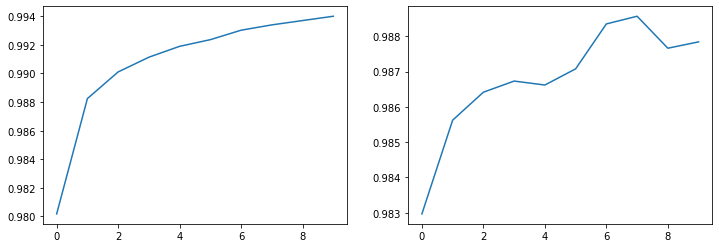

In [ ]:
train_accuracy = sp2.train_accuracy
dev_accuracy = sp2.dev_accuracy

figs,axs = plt.subplots(1,2,figsize=(12,4))
ax = axs[0]
ax.plot(train_accuracy)

ax = axs[1]
ax.plot(dev_accuracy)


We plotted the accuracy on both the training and dev set to tune the number of iterations we want the algorithm to run. The plots confirms that the higher the iterations the better is the result on the dev test. We decided indeed to set the parameter at 10 iterations.

In [46]:
#Test performance
test_instances = [(words,tags) for words,tags in zip(test_file.words,test_file.tags)]
print(f"Test accuracy:{sp2.evaluate(test_instances,'greedy')}")

Test accuracy:0.9902335171688404


In [48]:
greedy_acc = sp2.evaluate(test_instances,'greedy')

In [ ]:
print(sp2.predict('Il ministro è stato il primo a parlare'.split(),method='greedy'))

['DET', 'NOUN', 'AUX', 'AUX', 'DET', 'ADJ', 'ADP', 'VERB']


In [ ]:
print(sp2.predict('Oggi è un giorno storico per questo paese'.split(),method='greedy'))

['ADV', 'AUX', 'DET', 'NOUN', 'ADJ', 'ADP', 'DET', 'NOUN']


In [ ]:
print(sp2.predict("L'atto è stato ratificato".split(),method='greedy'))

['PRON', 'AUX', 'AUX', 'VERB']


# 5.1.2 Viterbi Model

We also trained a Viterbi Model on the data, to confront the comparison the performances and choose our baseline

In [ ]:
############# Very Long to run##### A saved pickle version of the model is available below
sp2 = StructuredPerceptron()
inference_method='viterbi'
%time sp2.fit(train_file, dev_file=dev_file, iterations=10, inference=inference_method)
#sp2.save('model_viterbi.pickle')

In [50]:
class StructuredPerceptron(object):

    def __init__(self):
        
        self.tags = set()
        self.feature_weights = defaultdict(lambda: defaultdict(float)) 
        self.weight_totals = defaultdict(lambda: defaultdict(float)) 
        self.timestamps = defaultdict(lambda: defaultdict(float)) 

        self.tag_dict = defaultdict(set) 
        self.train_accuracy = []
        self.dev_accuracy = []

        self.START = "__START__"
        self.END = "__END__"
        
        
    def normalize(self, word):
        return re.sub(urls, 'URL', re.sub(users, '@USER', re.sub(numbers, '0', word.strip().lower())))

    
    def evaluate(self, data_instances, method='greedy'):
        correct = 0
        total = 0
        for (words, tags) in data_instances:
            preds = self.predict(words, method=method)
            matches = sum(map(lambda x: int(x[0]==x[1]), zip(preds, tags)))
            correct += matches
            total += len(tags)
        
        return correct/total
        
    
    def fit(self,train_file, 
            dev_file=None, 
            iterations=10, 
            learning_rate=0.25, 
            inference='greedy', 
            verbose=False):
        
        instances = [(words, tags) for (words, tags) in zip(train_file.words,train_file.tags)]
        for (words, tags) in instances:
            self.tags.update(set(tags))

            for word, tag in zip(words, tags):
                self.tag_dict[self.normalize(word)].add(tag)
        
        if dev_file is not None:
            dev_instances = [(words, tags) for (words, tags) in zip(dev_file.words,dev_file.tags)]
            
        for iteration in range(1, iterations+1):
            correct = 0
            total = 0
            if verbose:
                print('Iteration {}'.format(iteration+1), file=sys.stderr, flush=True)
                print("*" * 15, file=sys.stderr, flush=True)

            random.shuffle(instances) #prevents weird cycles
            for i, (words, tags) in enumerate(instances):
                if i > 0:
                    if i%1000==0:
                        print('%s'%i, file=sys.stderr, flush=True)
                    elif i%20==0:
                        print('.', file=sys.stderr, flush=True, end='')

                prediction = self.predict(words, method=inference) 

                global_gold_features, global_prediction_features = self.get_global_features(words, prediction, tags)
                                    

                for tag, fids in global_gold_features.items():
                    for fid, count in fids.items():
                        nr_iters_at_this_weight = iteration - self.timestamps[fid][tag]
                        self.weight_totals[fid][tag] += nr_iters_at_this_weight * self.feature_weights[fid][tag]
                        self.timestamps[fid][tag] = iteration
                        self.feature_weights[fid][tag] += learning_rate * count

                for tag, fids in global_prediction_features.items():
                    for fid, count in fids.items():
                        nr_iters_at_this_weight = iteration - self.timestamps[fid][tag]
                        self.weight_totals[fid][tag] += nr_iters_at_this_weight * self.feature_weights[fid][tag]
                        self.timestamps[fid][tag] = iteration
                        self.feature_weights[fid][tag] -= learning_rate * count
                        
                correct += sum([int(predicted_tag == true_tag) for predicted_tag, true_tag in zip(prediction, tags)])
                total += len(tags)

                if verbose and i%1000==0:
                    print("current word accuracy:{:.2f}".format(correct/total))
                    print(list(zip(words, 
                                   [self.normalize(word) for word in words], 
                                   tags, 
                                   prediction)), file=sys.stderr, flush=True)
            
            print('\t{} features'.format(len(self.feature_weights)), file=sys.stderr, flush=True)
            print('\tTraining accuracy: {:.2f}\n'.format(correct/total), file=sys.stderr, flush=True)
            self.train_accuracy.append(correct/total)
            if dev_file is not None:
                print('\tDevelopment accuracy: {:.2f}\n'.format(self.evaluate(dev_instances, method=inference)), file=sys.stderr, flush=True)
                self.dev_accuracy.append(self.evaluate(dev_instances, method=inference))
         
        for feature, tags in self.feature_weights.items():
            for tag in tags:
                total = self.weight_totals[feature][tag]
                total += (iterations - self.timestamps[feature][tag]) * self.feature_weights[feature][tag]
                averaged = round(total / float(iterations), 3)
                self.feature_weights[feature][tag] = averaged


    def get_features(self, word, previous_tag2, previous_tag, words, i):

        prefix = word[:3]
        suffix = word[-3:]
        adverb_suffix = word[-5:]

        features = {
                    'PREFIX={}'.format(prefix),
                    'SUFFIX={}'.format(suffix),
                    'ADVERB_SUFFIX={}'.format(adverb_suffix),
                    'LEN<=3={}'.format(len(word)<=3),
                    'LENGTH={}'.format(len(word)),
                    'FIRST_LETTER={}'.format(word[0]),
                    'WORD={}'.format(word),
                    'NORM_WORD={}'.format(words[i]),
                    'PREV_WORD={}'.format(words[i-1]),
                    'PREV_WORD_PREFIX={}'.format(words[i-1][:3]),
                    'PREV_WORD_SUFFIX={}'.format(words[i-1][-3:]),
                    'PREV_WORD+WORD={}+{}'.format(words[i-1], words[i]),
                    'NEXT_WORD={}'.format(words[i+1]),
                    'NEXT_WORD_PREFIX={}'.format(words[i+1][:3]),
                    'NEXT_WORD_SUFFIX={}'.format(words[i+1][-3:]),
                    'WORD+NEXT_WORD={}'.format(word, words[i+1]),
                    'NEXT_2WORDS={}+{}'.format(words[i+1], words[i+2]),
                    'PREV_TAG={}'.format(previous_tag),                 
                    'PREV_TAG2={}'.format(previous_tag2),                 
                    'PREV_TAG_BIGRAM={}+{}'.format(previous_tag2, previous_tag),  
                    'PREV_TAG+WORD={}+{}'.format(previous_tag, word),            
                    'PREV_TAG+PREFIX={}_{}'.format(previous_tag, prefix),       
                    'PREV_TAG+SUFFIX={}_{}'.format(previous_tag, suffix),       
                    'WORD+TAG_BIGRAM={}+{}+{}'.format(word, previous_tag2, previous_tag),
                    'SUFFIX+2TAGS={}+{}+{}'.format(suffix, previous_tag2, previous_tag),
                    'PREFIX+2TAGS={}+{}+{}'.format(prefix, previous_tag2, previous_tag),
                    'LAST_LETTER{}'.format(word[-1]),
                    'PREV_WORD_ADVERB_SUFFIX={}'.format(words[i-1][-5:]),
                    'NEXT_WORD_ADVERB_SUFFIX={}'.format(words[i+1][-5:]),
                    'BIAS'
            }
        
        
        return features
    
    
    def get_global_features(self, words, predicted_tags, true_tags):

        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]

        global_gold_features = defaultdict(lambda: Counter())
        global_prediction_features = defaultdict(lambda: Counter())

        prev_predicted_tag = self.START
        prev_predicted_tag2 = self.START
        
        for j, (word, predicted_tag, true_tag) in enumerate(zip(words, predicted_tags, true_tags)):
            prediction_features = self.get_features(word, prev_predicted_tag2, prev_predicted_tag, context, j+1)

            global_prediction_features[predicted_tag].update(prediction_features)
            global_gold_features[true_tag].update(prediction_features)

            prev_predicted_tag2 = prev_predicted_tag
            prev_predicted_tag = predicted_tag

        return global_gold_features, global_prediction_features
            
    
    def get_scores(self, features):

        scores = defaultdict(float)
        for feature in features:
            if feature not in self.feature_weights:
                continue
            weights = self.feature_weights[feature]
            for tag, weight in weights.items():
                scores[tag] += weight

        if not scores:
            scores[list(self.tags)[0]] = 1
        
        return scores


    def predict(self, words, method='greedy'):
 
        if method == 'greedy':
            return self.predict_greedy(words)
        elif method == 'viterbi':
            return self.predict_viterbi(words)


    def predict_viterbi(self, words):

        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]

        N = len(words)
        M = len(self.tags)
        tags = sorted(self.tags)

        Q = np.ones((M, N)) * float('-Inf')
        backpointers = np.ones((M, N), dtype=np.int16) * -1 

        features = self.get_features(words[0], self.START, self.START, context, 1)
        scores = self.get_scores(features)
        allowed_initial_tags = self.tag_dict[context[1]]

        for j in range(M):
            if not allowed_initial_tags or tags[j] in allowed_initial_tags:
                Q[j,0] = scores[tags[j]]

        for i in range(1, N):
            allowed_tags = self.tag_dict[context[i+1]]

            for j in range(M):
                best_score = 0.0
                prev_tag = tags[j]

                allowed_previous_tags = self.tag_dict[context[i]]
                if allowed_previous_tags and prev_tag not in allowed_previous_tags:
                    continue

                best_before = Q[j,i-1] 

                for k in range(M):
                    if i == 1:
                        prev2_tag = self.START
                    else:
                        prev2_tag = tags[k]
                        allowed_previous2_tags = self.tag_dict[context[i-1]]
                        if allowed_previous2_tags and prev2_tag not in allowed_previous2_tags:
                            continue

                    features = self.get_features(words[i], prev2_tag, prev_tag, context, i+1)
                    scores = self.get_scores(features)

                    for t in range(M):
                        tag = tags[t]
                        if not allowed_tags or tag in allowed_tags:
                            tag_score = best_before + scores[tag]

                            if tag_score > best_score:
                                Q[t,i] = tag_score
                                best_score = tag_score
                                backpointers[t,i] = j

        best_id = Q[:,-1].argmax()

        predtags = [tags[best_id]]

        for i in range(N-1,0,-1):
            idx = backpointers[best_id, i]
            predtags.append(tags[idx])
            best_id = idx

        return predtags[::-1]        

        
    def save(self, file_name):

        print("saving model...", end=' ', file=sys.stderr)
        with open(file_name, "wb") as model:
            save_feature_weights = defaultdict(lambda: defaultdict(float))
            save_feature_weights.update(self.feature_weights)
            save_tag_dict = defaultdict(set)
            save_tag_dict.update(self.tag_dict)

            save_feature_weights.default_factory = None
            save_tag_dict.default_factory = None
            pickle.dump((save_feature_weights, save_tag_dict,self.tags,self.train_accuracy,self.dev_accuracy),
                     model, -1)
        print("done", file=sys.stderr)


    def load(self, file_name):
 
        print("loading model...", end=' ', file=sys.stderr)
        with open(file_name, 'rb') as model:
            try:
                parameters = pickle.load(model)
            except IOError:
                msg = ("No such model file.")
                raise MissingCorpusError(msg)

            feature_weights, tag_dict, tags= parameters
            self.tags = tags

            self.feature_weights = defaultdict(lambda: defaultdict(float))
            self.tag_dict = defaultdict(set)
            
            self.feature_weights.update(feature_weights)
            self.tag_dict.update(tag_dict)
        print("done", file=sys.stderr)
        return None

In [51]:
sp3 = StructuredPerceptron()
sp3.load('model_viterbi.pickle')

loading model... done


In [52]:
test_instances = [(words,tags) for words,tags in zip(test_file.words,test_file.tags)]
print(f"Test accuracy:{sp3.evaluate(test_instances,'viterbi')}")
viterbi_acc = sp3.evaluate(test_instances,'viterbi')

Test accuracy:0.9792884478072648


In [ ]:
print(sp3.predict('Il ministro è stato il primo a parlare'.split(),method='viterbi'))

['DET', 'NOUN', 'AUX', 'AUX', 'DET', 'ADJ', 'ADP', 'VERB']


In [ ]:
print(sp2.predict("L'atto è stato ratificato".split(),method='greedy'))

['PRON', 'AUX', 'AUX', 'VERB']


In [ ]:
print(sp3.predict("L'atto è stato ratificato".split(), method='viterbi'))

['SYM', 'AUX', 'AUX', 'VERB']


# 5.2 Neural Net Architecture 

In [1]:
import pandas as pd
import numpy as np

In [2]:
data_original = pd.read_csv("cleaned_nonans.csv")

data = data_original[['words','pos_tags']]

In [3]:
data = pd.read_csv("cleaned_nonans.csv")


In [4]:
words = [] 
for row in range(data.shape[0]):
    trans = data.words[row].split()
    sentence = []
    for word in trans:
        sentence.append(word)
    words.append(sentence)

In [5]:
pos_tags = [] 
for row in range(data.shape[0]):
    trans = data.pos_tags[row].split()
    sentence = []
    for tag in trans:
        sentence.append(tag)
    pos_tags.append(sentence)

In [6]:
clean_words = []
clean_tags = []

for i in range(len(words)):
    sentence_w = []
    sentence_t = []
    for j in range(len(words[i])):
        if pos_tags[i][j] != "_":
            sentence_w.append(words[i][j])
            sentence_t.append(pos_tags[i][j])
    clean_words.append(sentence_w)
    clean_tags.append(sentence_t)
    
    

In [7]:
len(clean_words)==len(clean_tags), len(clean_words)

(True, 13170)

In [8]:
np.random.seed(2)
a = np.arange(len(clean_words))
np.random.shuffle(a)
train_index = a[:len(clean_words)*3//5]
dev_index = a[len(clean_words)*3//5:len(clean_words)*4//5]
test_index = a[len(clean_words)*4//5:]

In [9]:
train_words = []
train_tags = []
for i in train_index:
    train_words.append(clean_words[i])
    train_tags.append(clean_tags[i])
dev_words = []
dev_tags = []
for i in dev_index:
    dev_words.append(clean_words[i])
    dev_tags.append(clean_tags[i])
test_words = []
test_tags = []
for i in test_index:
    test_words.append(clean_words[i])
    test_tags.append(clean_tags[i])

In [10]:
train_file = pd.DataFrame({'words':train_words,'tags':train_tags})
dev_file = pd.DataFrame({'words':dev_words,'tags':dev_tags})
test_file = pd.DataFrame({'words':test_words,'tags':test_tags})

In [11]:
instances = [(word,tags) for (word,tags) in zip(dev_file.words,dev_file.tags)]

# Preparation 

In [12]:
# collect known word tokens and tags
train_instances = [(word,tags) for (word,tags) in zip(train_file.words,train_file.tags)]
wordset, tagset = set(), set()
for (words, tags) in train_instances:
    tagset.update(set(tags))
    wordset.update(set(words))

# map words and tags into ints
PAD = '-PAD-'
UNK = '-UNK-'
word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
word2int[PAD] = 0  # special token for padding
word2int[UNK] = 1  # special token for unknown words
 
tag2int = {tag: i + 1 for i, tag in enumerate(sorted(tagset))}
tag2int[PAD] = 0
# to translate it back
int2tag = {i:tag for tag, i in tag2int.items()}


def convert2ints(instances):
    result = []
    for (words, tags) in instances:
        word_ints = [word2int.get(word, 1) for word in words]
        tag_ints = [tag2int[tag] for tag in tags]
        result.append((word_ints, tag_ints))
    return result        

In [13]:
test_instances = [(words, tags) for (words, tags) in zip(test_file.words,test_file.tags)]

train_instances_int = convert2ints(train_instances)
test_instances_int = convert2ints(test_instances)

train_sentences, train_tags = zip(*train_instances_int) 
test_sentences, test_tags = zip(*test_instances_int) 

In [14]:
MAX_LENGTH = len(max(train_sentences, key=len)) + len(max(train_sentences, key=len))//15
print(MAX_LENGTH)

8085


In [15]:
from keras.preprocessing.sequence import pad_sequences
 
# add special padding at the end of every instance, up to MAX_LENGTH
train_sentences = pad_sequences(train_sentences, maxlen=MAX_LENGTH, padding='post')
test_sentences = pad_sequences(test_sentences, maxlen=MAX_LENGTH, padding='post')
train_tags = pad_sequences(train_tags, maxlen=MAX_LENGTH, padding='post')
test_tags = pad_sequences(test_tags, maxlen=MAX_LENGTH, padding='post')

In [16]:
from tensorflow.keras.utils import to_categorical

train_tags_1hot = to_categorical(train_tags, len(tag2int))
test_tags_1hot = to_categorical(test_tags, len(tag2int))

# 5.2.1 CNN

In [17]:
from keras.models import Model
from keras.layers import Input, Embedding
from keras.layers import Bidirectional, LSTM
from keras.layers import Dropout, Dense, Activation
import numpy as np

# Set a random seed for reproducibility
np.random.seed(42)

inputs = Input((MAX_LENGTH, ), 
               name='word_IDs')
embeddings = Embedding(input_dim=len(word2int), 
                       output_dim=128, 
                       mask_zero=True, 
                       name='embeddings')(inputs)
lstm = LSTM(units=256,
              return_sequences=True,
              name="LSTM")(embeddings)
dropout = Dropout(0.3, name='dropout')(lstm)
lstm_out = Dense(len(tag2int), name='output')(dropout)
output = Activation('softmax', name='softmax')(lstm_out)

model = Model(inputs=[inputs], outputs=[output])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_IDs (InputLayer)       [(None, 8085)]            0         
                                                                 
 embeddings (Embedding)      (None, 8085, 128)         8206208   
                                                                 
 LSTM (LSTM)                 (None, 8085, 256)         394240    
                                                                 
 dropout (Dropout)           (None, 8085, 256)         0         
                                                                 
 output (Dense)              (None, 8085, 18)          4626      
                                                                 
 softmax (Activation)        (None, 8085, 18)          0         
                                                                 
Total params: 8,605,074
Trainable params: 8,605,074
Non-train

In [18]:
batch_size = 16
epochs = 5

# compile the model we have defined above
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

# run training and capture ouput log
history = model.fit(train_sentences, train_tags_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

loss, accuracy = model.evaluate(test_sentences, test_tags_1hot,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/5
396/396 [==============================] - 52s 112ms/step - loss: 0.0391 - accuracy: 0.8011 - val_loss: 0.0060 - val_accuracy: 0.9661
Epoch 2/5
396/396 [==============================] - 42s 105ms/step - loss: 0.0051 - accuracy: 0.9706 - val_loss: 0.0046 - val_accuracy: 0.9719
Epoch 3/5
396/396 [==============================] - 41s 104ms/step - loss: 0.0039 - accuracy: 0.9761 - val_loss: 0.0043 - val_accuracy: 0.9736
Epoch 4/5
396/396 [==============================] - 41s 104ms/step - loss: 0.0035 - accuracy: 0.9783 - val_loss: 0.0042 - val_accuracy: 0.9746
Epoch 5/5
165/165 [==============================] - 7s 40ms/step - loss: 0.0040 - accuracy: 0.9748
Test loss: 0.004044808447360992
Test accuracy: 0.9747949242591858


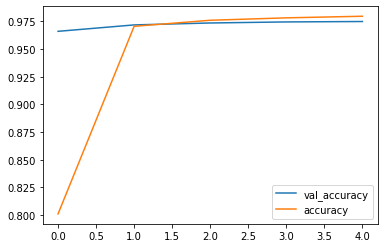

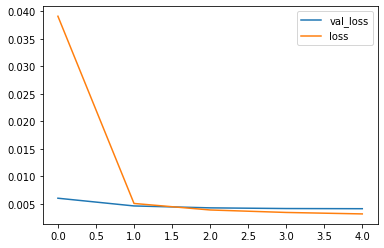

In [19]:
%matplotlib inline
import pandas as pd
import seaborn

df = pd.DataFrame(history.history)
df[['val_accuracy', 'accuracy']].plot.line();
df[['val_loss', 'loss']].plot.line();

In [20]:
loss, accuracy = model.evaluate(test_sentences, test_tags_1hot,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

CNN_loss = loss 
CNN_accuracy = accuracy 

165/165 [==============================] - 7s 44ms/step - loss: 0.0040 - accuracy: 0.9748
Test loss: 0.004044808447360992
Test accuracy: 0.9747949242591858


# 5.2.2 Bi-LSTM

In [21]:
from keras.layers import Bidirectional

# Set a random seed for reproducibility
np.random.seed(42)

inputs = Input((MAX_LENGTH, ), 
               name='word_IDs')
embeddings = Embedding(input_dim=len(word2int), 
                       output_dim=128, 
                       mask_zero=True, 
                       name='embeddings')(inputs)
#wrap the LSTM in a Bidirectional wrapper
bilstm = Bidirectional(LSTM(units=256, 
                            return_sequences=True), 
                       name="Bi-LSTM")(embeddings)
dropout = Dropout(0.3, name='dropout')(bilstm)
bilstm_out = Dense(len(tag2int), name='output')(dropout)
output = Activation('softmax', name='softmax')(bilstm_out)

model_bilstm = Model(inputs=[inputs], outputs=[output])
model_bilstm.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_IDs (InputLayer)       [(None, 8085)]            0         
                                                                 
 embeddings (Embedding)      (None, 8085, 128)         8206208   
                                                                 
 Bi-LSTM (Bidirectional)     (None, 8085, 512)         788480    
                                                                 
 dropout (Dropout)           (None, 8085, 512)         0         
                                                                 
 output (Dense)              (None, 8085, 18)          9234      
                                                                 
 softmax (Activation)        (None, 8085, 18)          0         
                                                                 
Total params: 9,003,922
Trainable params: 9,003,922
Non-tra

Epoch 1/5
396/396 [==============================] - 97s 229ms/step - loss: 0.0306 - accuracy: 0.8455 - val_loss: 0.0034 - val_accuracy: 0.9820
Epoch 2/5
396/396 [==============================] - 84s 212ms/step - loss: 0.0026 - accuracy: 0.9864 - val_loss: 0.0025 - val_accuracy: 0.9861
Epoch 3/5
396/396 [==============================] - 84s 211ms/step - loss: 0.0016 - accuracy: 0.9910 - val_loss: 0.0022 - val_accuracy: 0.9878
Epoch 4/5
396/396 [==============================] - 83s 211ms/step - loss: 0.0013 - accuracy: 0.9926 - val_loss: 0.0021 - val_accuracy: 0.9885
Epoch 5/5
396/396 [==============================] - 82s 207ms/step - loss: 0.0011 - accuracy: 0.9937 - val_loss: 0.0021 - val_accuracy: 0.9886


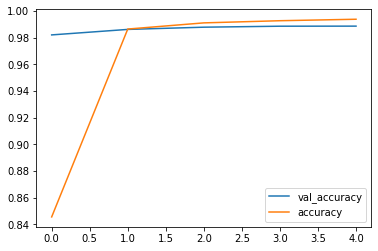

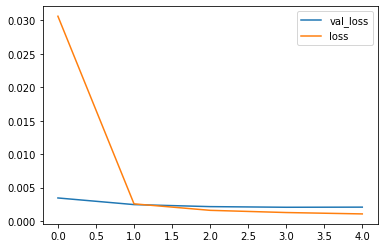

In [22]:
batch_size = 16
epochs = 5

model_bilstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

history_bilstm = model_bilstm.fit(train_sentences, train_tags_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

df = pd.DataFrame(history_bilstm.history)
df[['val_accuracy', 'accuracy']].plot.line();
df[['val_loss', 'loss']].plot.line();

In [23]:
loss, accuracy = model_bilstm.evaluate(test_sentences, test_tags_1hot,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

BiLSTM_loss = loss 
BiLSRM_accuracy = accuracy 

165/165 [==============================] - 13s 80ms/step - loss: 0.0021 - accuracy: 0.9885
Test loss: 0.0020579358097165823
Test accuracy: 0.9884881377220154


# 5.2.3 Sequential API Model
Although changes should not be excessive but mostly due to stiochasticty we also ran a Bi-LSTM model utilising the sequential API coding method. We did observe a slightly higher performance which, as mentioned, is likely due to the great stochasticity of such models.

In [24]:
from keras.models import Sequential
from keras.layers import InputLayer
np.random.seed(42)

model_seq = Sequential()
model_seq.add(InputLayer(input_shape=(MAX_LENGTH, ), name="word_IDs"))
model_seq.add(Embedding(len(word2int), 128, mask_zero=True, name='embeddings'))
model_seq.add(Bidirectional(LSTM(256, return_sequences=True), name='bi-LSTM'))
model_seq.add(Dropout(0.3, name='dropout'))
model_seq.add(Dense(len(tag2int), name='output'))
model_seq.add(Activation('softmax', name='softmax'))
model_seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (Embedding)      (None, 8085, 128)         8206208   
                                                                 
 bi-LSTM (Bidirectional)     (None, 8085, 512)         788480    
                                                                 
 dropout (Dropout)           (None, 8085, 512)         0         
                                                                 
 output (Dense)              (None, 8085, 18)          9234      
                                                                 
 softmax (Activation)        (None, 8085, 18)          0         
                                                                 
Total params: 9,003,922
Trainable params: 9,003,922
Non-trainable params: 0
_________________________________________________________________


In [25]:
batch_size = 32
epochs = 5

model_seq.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model_seq.fit(train_sentences, train_tags_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

loss, accuracy = model_seq.evaluate(test_sentences, test_tags_1hot,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/5
198/198 [==============================] - 69s 313ms/step - loss: 0.0584 - accuracy: 0.7047 - val_loss: 0.0066 - val_accuracy: 0.9681
Epoch 2/5
198/198 [==============================] - 58s 294ms/step - loss: 0.0045 - accuracy: 0.9776 - val_loss: 0.0032 - val_accuracy: 0.9829
Epoch 3/5
198/198 [==============================] - 59s 296ms/step - loss: 0.0024 - accuracy: 0.9875 - val_loss: 0.0025 - val_accuracy: 0.9861
Epoch 4/5
198/198 [==============================] - 59s 298ms/step - loss: 0.0017 - accuracy: 0.9905 - val_loss: 0.0023 - val_accuracy: 0.9869
Epoch 5/5
83/83 [==============================] - 9s 111ms/step - loss: 0.0021 - accuracy: 0.9879
Test loss: 0.0020988646429032087
Test accuracy: 0.9878607988357544


In [26]:
api_basic_acc = accuracy 
api_basic_loss = loss

In [27]:
batch_size = 16
epochs = 5

model_seq.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model_seq.fit(train_sentences, train_tags_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

loss, accuracy = model_seq.evaluate(test_sentences, test_tags_1hot,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

api_16_loss = loss 
api_16_accuracy = accuracy

Epoch 1/5
396/396 [==============================] - 94s 222ms/step - loss: 0.0013 - accuracy: 0.9924 - val_loss: 0.0022 - val_accuracy: 0.9880
Epoch 2/5
396/396 [==============================] - 83s 210ms/step - loss: 0.0011 - accuracy: 0.9935 - val_loss: 0.0023 - val_accuracy: 0.9874
Epoch 3/5
396/396 [==============================] - 84s 211ms/step - loss: 9.2178e-04 - accuracy: 0.9945 - val_loss: 0.0021 - val_accuracy: 0.9888
Epoch 4/5
396/396 [==============================] - 82s 208ms/step - loss: 7.7729e-04 - accuracy: 0.9954 - val_loss: 0.0022 - val_accuracy: 0.9887
Epoch 5/5
165/165 [==============================] - 13s 79ms/step - loss: 0.0021 - accuracy: 0.9892
Test loss: 0.0021192056592553854
Test accuracy: 0.9892045855522156


In [53]:
print(CNN_accuracy)
print(BiLSRM_accuracy)
print(api_basic_acc)
print(api_16_accuracy)
print(greedy_acc)
print(viterbi_acc)





0.9747949242591858
0.9884881377220154
0.9878607988357544
0.9892045855522156
0.9902335171688404
0.9792884478072648


In [56]:
pd.DataFrame(data = [greedy_acc, viterbi_acc,CNN_accuracy,BiLSRM_accuracy,api_basic_acc,api_16_accuracy], index = ['greedy','viterbi','CNN','BiLSTM','API_basic','API_batch=16']).T

,greedy,viterbi,CNN,BiLSRM,API_basic,API_batch=16
0,0.990234,0.979288,0.974795,0.988488,0.987861,0.989205


## Conclusion

In conclusion, with respect to our goal regarding structured prediction we have beeen able to build an accurate POS tagger specialized in italian language. 
Across the models we trained, we indeed registered accuracies on test always above 97%, in particular the best result was yield by the greedy structured perceptron, with an accuracy on test data of more than 99%.